In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, SimpleRNN
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, accuracy_score
from sklearn.metrics import average_precision_score, roc_auc_score

%matplotlib inline

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

[]


Today we will work with time series. Compared to conventional tabular data in time series there is one additional dimension, usually a time but not always. Examples of time series are the number of cars on a given street each hour, and energy consumption each minute. Also, series like text can be treated with similar techniques.

Let's create a dataset for our exercise. We will use a trigonometric function with some noise.

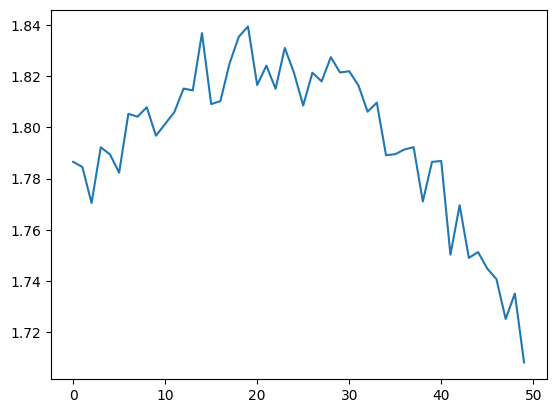

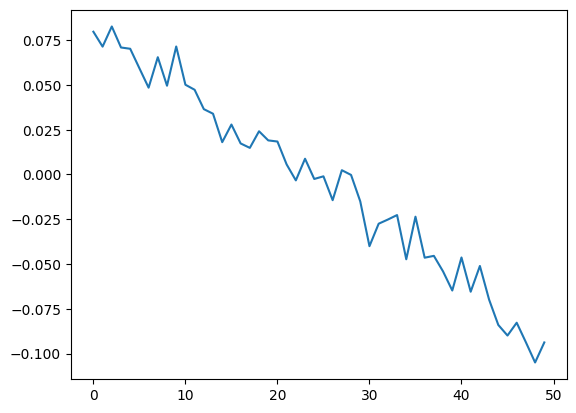

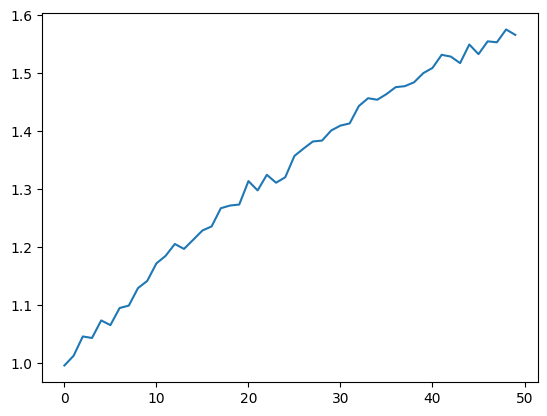

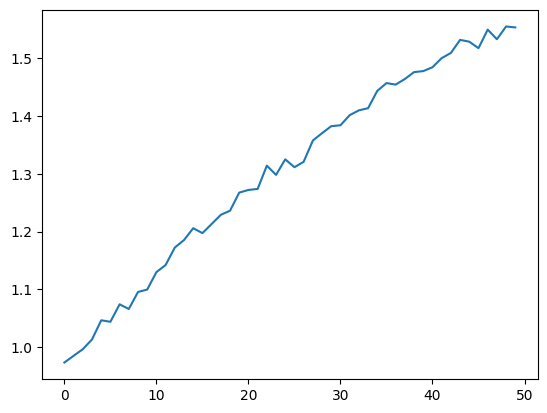

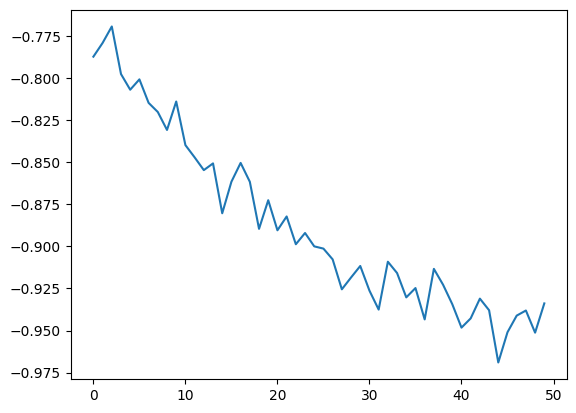

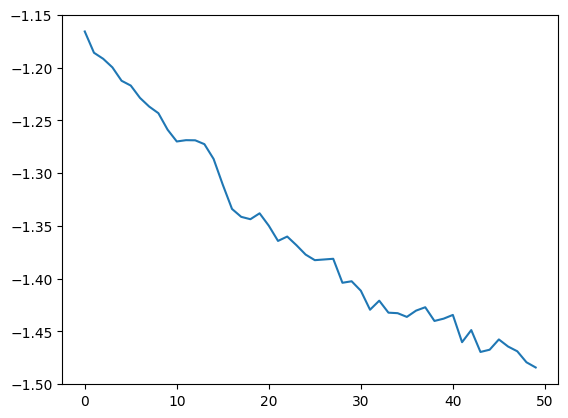

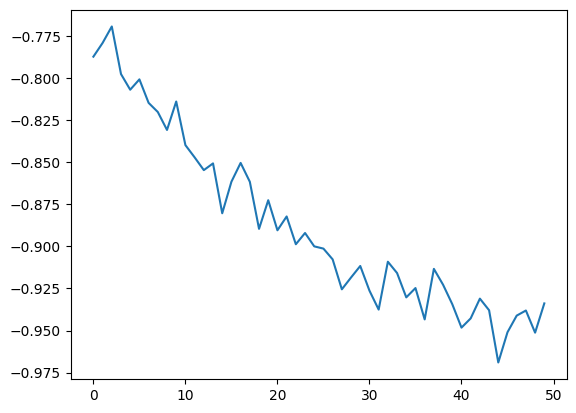

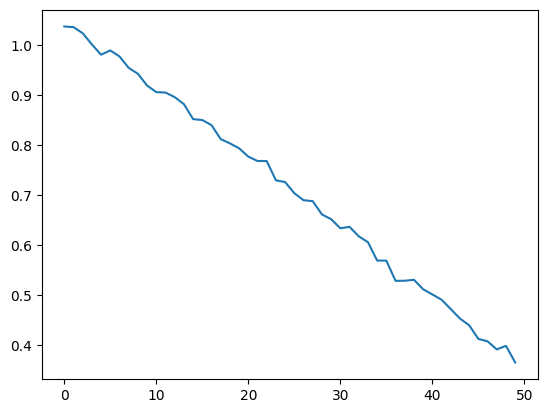

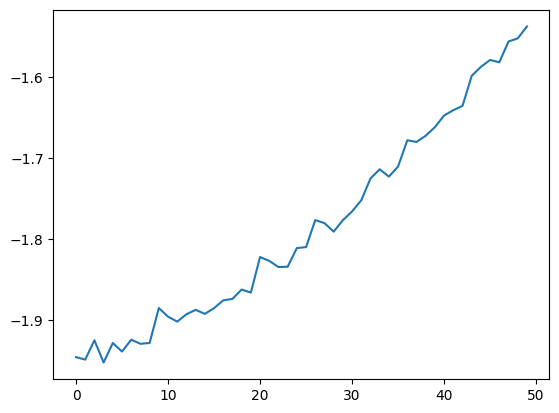

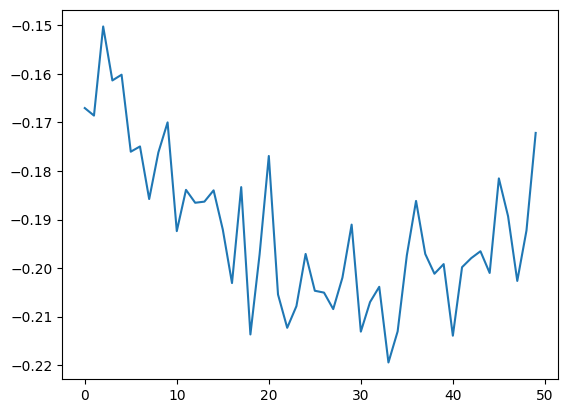

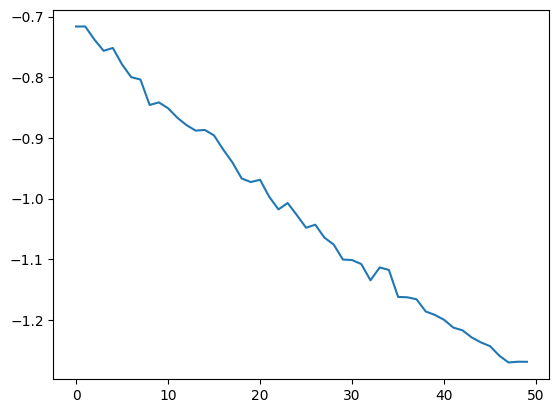

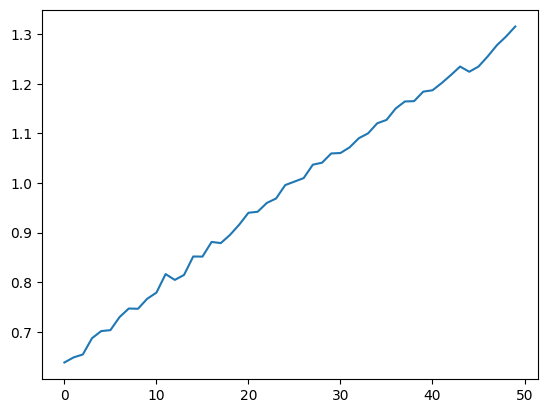

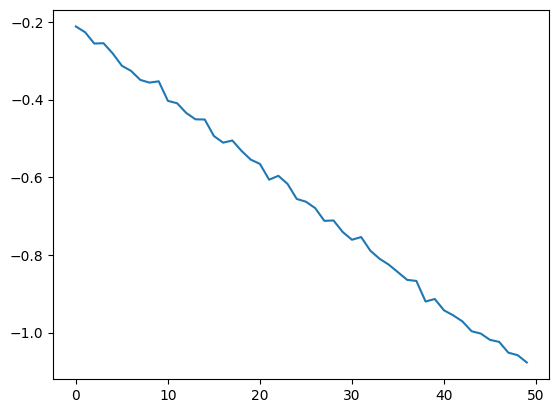

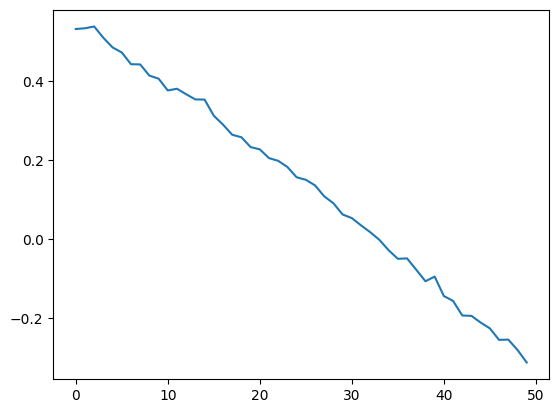

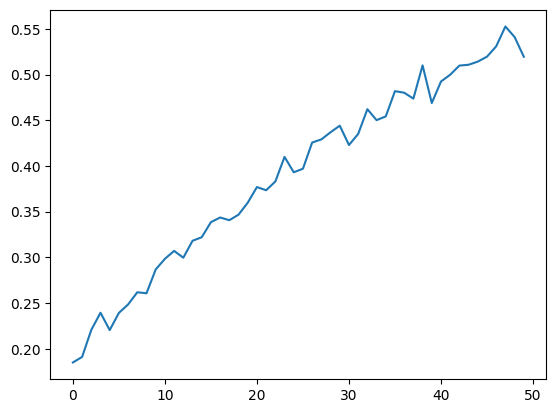

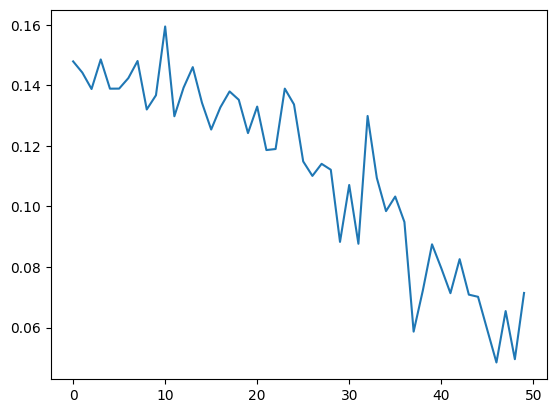

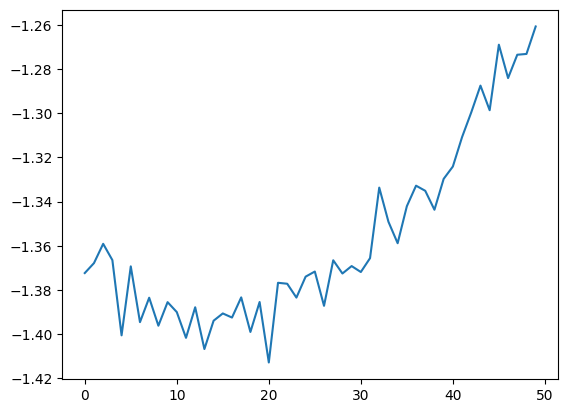

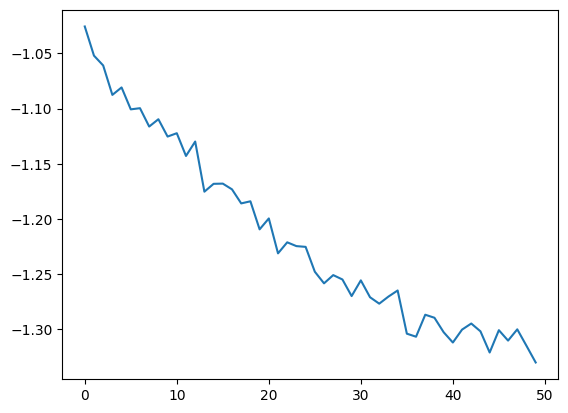

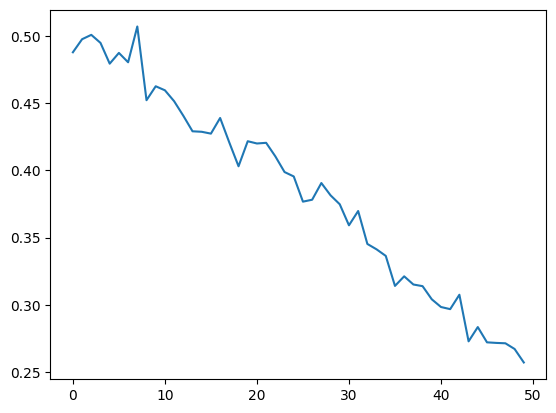

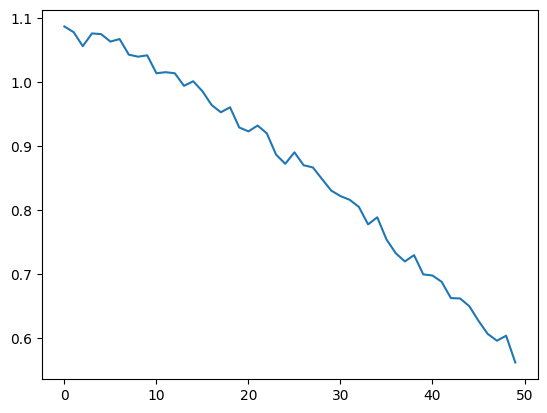

In [4]:
data = np.sin(np.linspace(0, 100, 10000)) + np.sin(np.linspace(13, 150, 10000))
data += np.random.randn(*data.shape)/100
for i in np.random.randint(0, 9000, 20):
    plt.plot(data[i:i+50])
    plt.show()

In [5]:
data.shape

(10000,)

As the first step let's use a part of this series and try to predict the next value. To prepare data function sliding_window_view might be useful. What's important it creates view not a new array so we don't waste memory.

In [6]:
np.lib.stride_tricks.sliding_window_view(np.arange(200), 50)

array([[  0,   1,   2, ...,  47,  48,  49],
       [  1,   2,   3, ...,  48,  49,  50],
       [  2,   3,   4, ...,  49,  50,  51],
       ...,
       [148, 149, 150, ..., 195, 196, 197],
       [149, 150, 151, ..., 196, 197, 198],
       [150, 151, 152, ..., 197, 198, 199]])

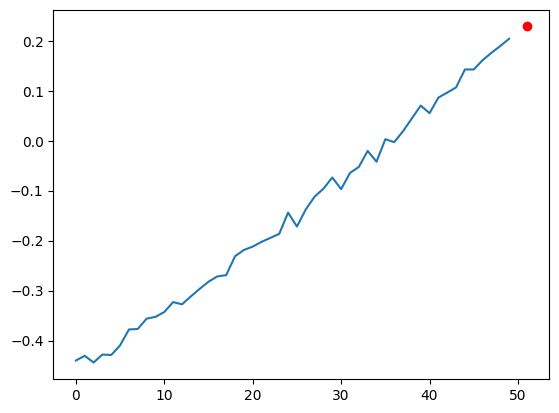

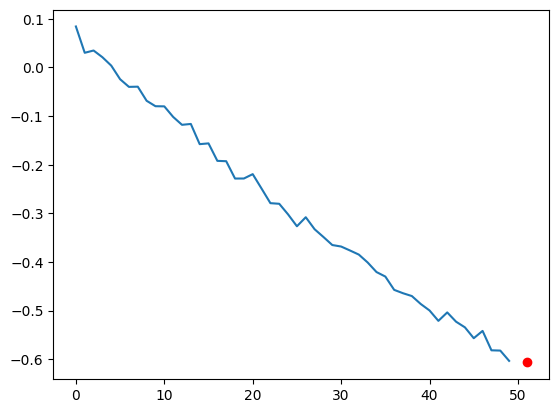

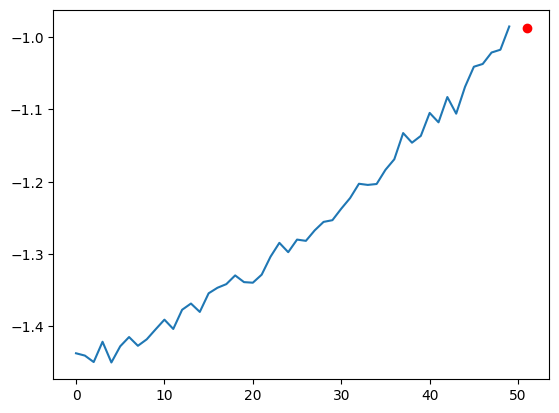

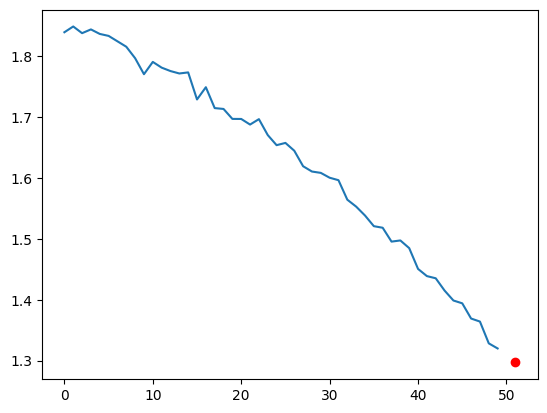

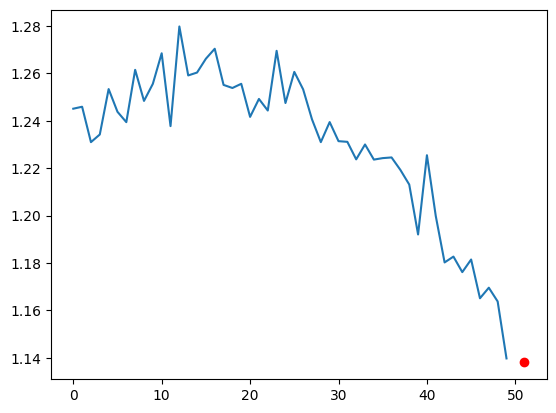

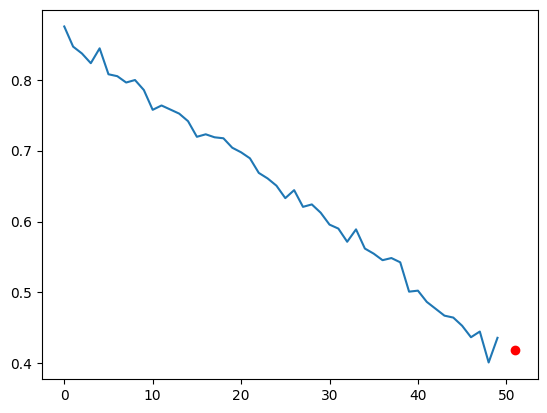

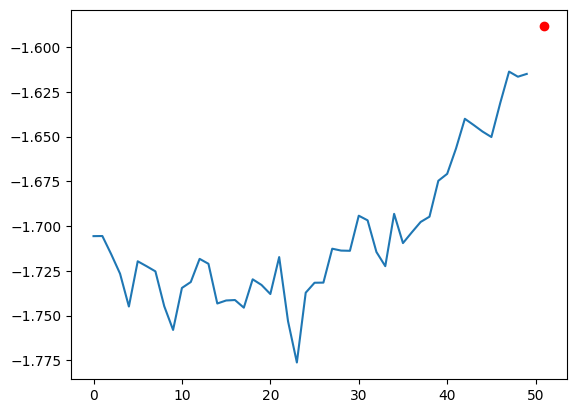

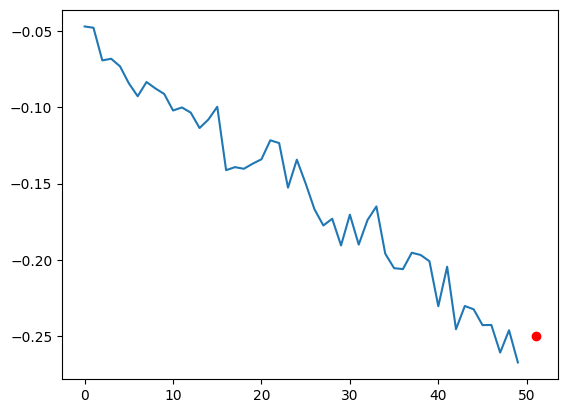

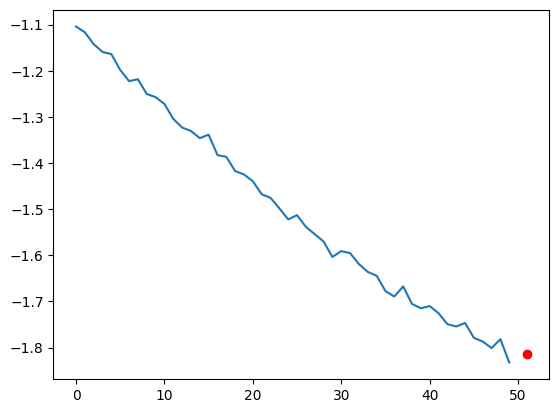

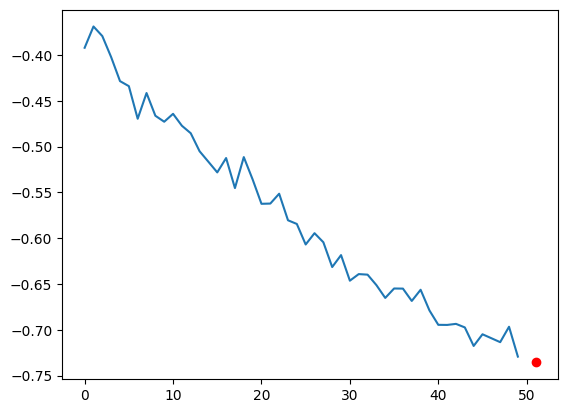

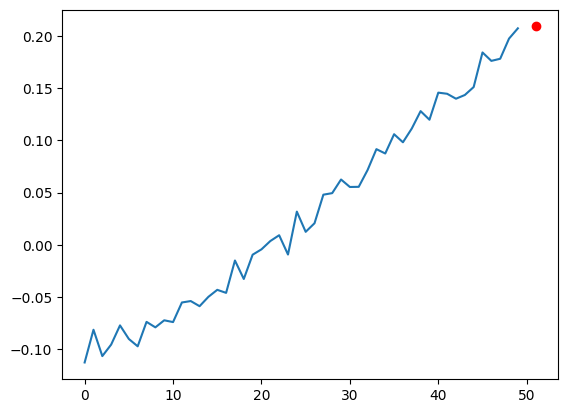

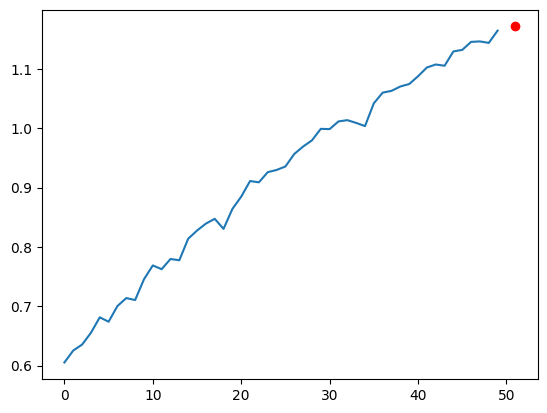

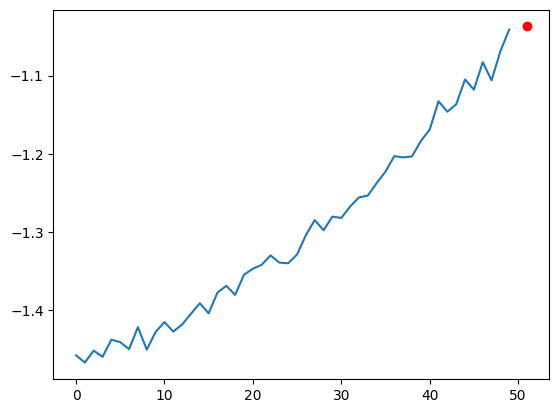

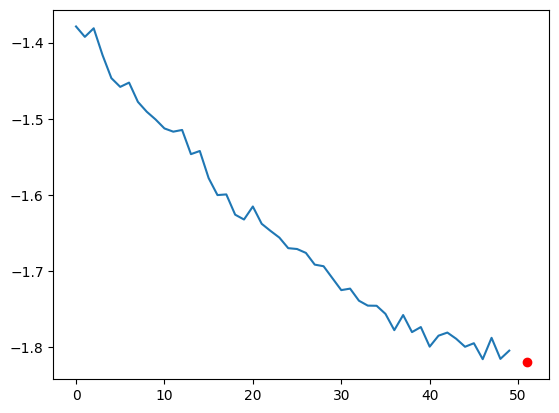

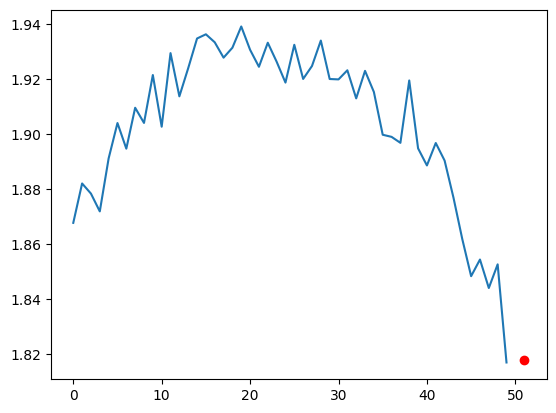

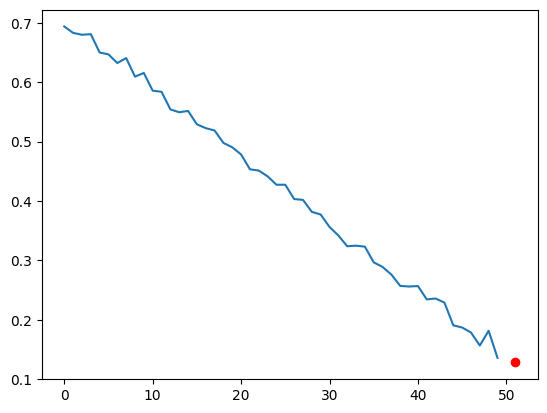

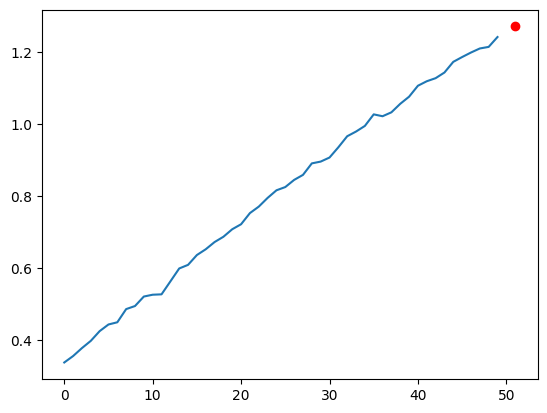

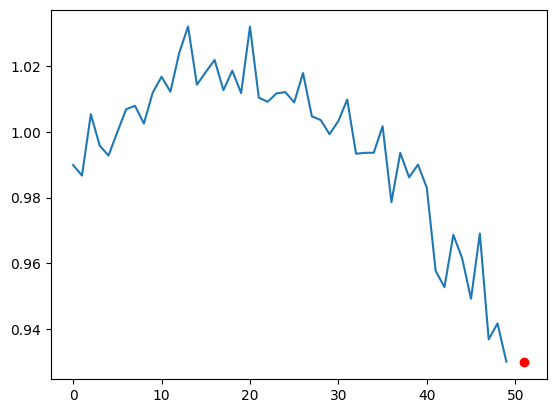

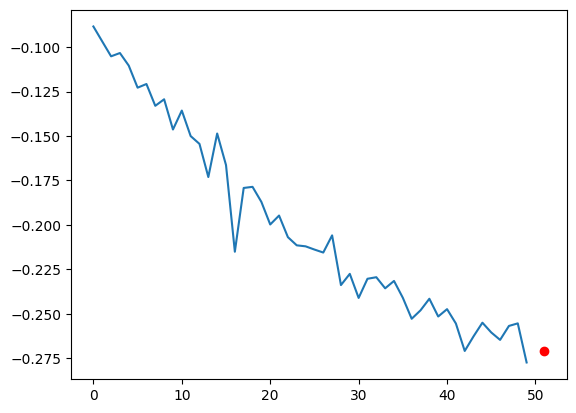

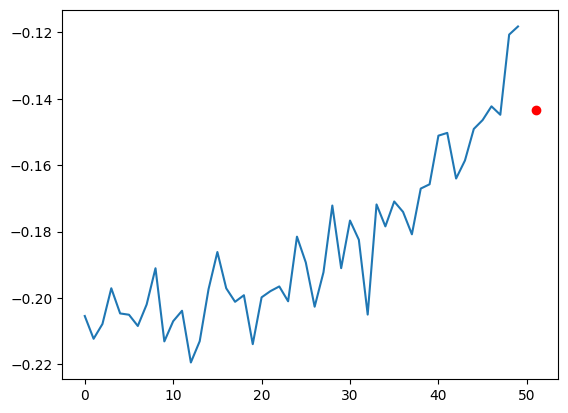

In [7]:
windowSize = 50
x = np.lib.stride_tricks.sliding_window_view(data, windowSize)[:-1] # for the last entry we will not have a target
y = data[windowSize:]
for i in np.random.randint(0, 9000, 20):
    plt.plot(x[i])
    plt.plot(windowSize+1, y[i], 'ro')
    plt.show()

<details>

<summary>We need to split the data into training, validation, and test sets. This time it might not be the best idea to split the data randomly. Do you know why? Click to see a hint
    </summary>
Imagine such a situation, in the test set you have a prediction of the 200th timestamp based on timestamps number 150-199, and in the training set, there is a prediction of the 201st timestamp based on timestamps number 151-200.
     
</details>

We don't want any overlap between these sets. Imagine we have 500 timestamps. If the last training row consist of timestamps 250-299 as predictors and 300 as a target then first validation row shouldn't be 251-300 but 301-350

**Task 1** <br>Split data into training, validation, and test sets

In [8]:
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1


Time series can be processed using neural networks. The very basic approach would be to treat each timestamp as separate input and use a classical Dense layer. What should be an input shape of such a network? 

**Task2** <br>Create, fit and evaluate such a model

In [9]:
pred = model.predict(test_x)
for i in np.random.randint(0, len(test_y), 10):
    plt.plot(range(windowSize), test_x[i], label='predictor')
    plt.plot(windowSize+1, test_y[i], "bo", label="y_true")
    plt.plot(windowSize+1, pred[i], "ro", label="y_pred")
    plt.legend()
    plt.grid()
    plt.show()

NameError: name 'model' is not defined

There are a few problems with this approach. Firstly we assume a fixed number of timestamps, secondly, we don't treat the data as a series. There are approaches without these problems. Let's try to invent them.

The first idea would be to apply a dense layer to each timestamp independently. How many parameters are in such a model? The problem is the size of the output would be equal to the size of the input and each timestamp of the output would be produced based on just one timestamp from the input. <br>
We can slightly modify such a model to create the most basic version of a recurrent neural network. We are going to add one additional input to the model and as this input, we will use the output from the previous timestamp. This model is already implemented in keras and is called a Simple RNN

In [ ]:
seqLen = 50
model = Sequential()
model.add(SimpleRNN(64, input_shape=(seqLen,1)))
model.add(Dense(1))
model.compile(loss='mse')
model.summary()

Now the input is two-dimensional (number of timestamps, number of features) so we have to provide two numbers as the input shape. In general, we should reshape our input data, but since we have just one feature it will work anyway.

In [ ]:
early = EarlyStopping(patience=7, restore_best_weights=True)
model.fit(train_x,train_y, batch_size=64, epochs=50, validation_data=[val_x, val_y], callbacks=[early])

In [ ]:
model.evaluate(test_x, test_y)

In [ ]:
pred = model.predict(test_x)
for i in np.random.randint(0, len(test_y), 10):
    plt.plot(range(windowSize), test_x[i], label='predictor')
    plt.plot(windowSize+1, test_y[i], "bo", label="y_true")
    plt.plot(windowSize+1, pred[i], "ro", label="y_pred")
    plt.legend()
    plt.grid()
    plt.show()

Check if number of parameters changes with sequence length

In [ ]:
seqLen = 500
model = Sequential()
model.add(SimpleRNN(1, input_shape=(seqLen,1)))
model.summary()

Can we not specify sequence length at all?

In [ ]:
seqLen = None
model = Sequential()
model.add(SimpleRNN(1, input_shape=(seqLen,1)))
model.summary()

I've said before that in rnn models we have an output for each timestamp but after the training there was just one number returned. Although the intermediate outputs are calculated, the default approach is to return just the last one. We can change this behavior by setting parameter return_sequences to true.

In [ ]:
seqLen = 50
model = Sequential()
model.add(SimpleRNN(1, input_shape=(seqLen,1)))
model.summary()

In [ ]:
model.predict(test_x[:3]).shape, model.predict(test_x[:3])

In [ ]:
seqLen = 50
model = Sequential()
model.add(SimpleRNN(1, return_sequences=True, input_shape=(seqLen,1)))
model.summary()

In [ ]:
model.predict(test_x[:3]).shape, model.predict(test_x[:3])

**Task 3** <br>create a model with more than one recurrent layer.

In [ ]:
seqLen = 50
model = Sequential()

model.summary()

There is one serious problem with SimpleRNN, these models don't have a good memory. When processing let's say timestamp number 20 there is basically no information left from the beginning of the series. That's why two extensions of it are much more popular: LSTM and GRU. Inside each cell there are some mini neural networks determining how much information to forget and add to the current state. We will not go deeply into detail about how these cells work. That would be covered by a lecture. 

https://www.researchgate.net/profile/Savvas-Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell_W640.jpg

LSTMs are more complex than GRU thus they are more suitable for harder tasks while GRU cells are rather lightweight and require less computational power but might perform not as well. Both cells already have nonlinear transofmrations inside so there is no need to apply another activation function.

In [ ]:
model = Sequential()
model.add(SimpleRNN(2, input_shape=(None,2)))
model.summary()

In [ ]:
model = Sequential()
model.add(GRU(2, input_shape=(None,2)))
model.summary()

In [ ]:
model = Sequential()
model.add(LSTM(2, input_shape=(None,2)))
model.summary()

**Task 4** <br>Repeat the prediction task but use GRU instead of SimpleRNN. Check number of parameters while using the same number of layers and neurons

In [ ]:
early = EarlyStopping(patience=7, restore_best_weights=True)
model.fit(train_x,train_y, batch_size=64, epochs=50, validation_data=[val_x, val_y], callbacks=[early])

In [ ]:
model.evaluate(test_x, test_y)

In [ ]:
pred = model.predict(test_x)
for i in np.random.randint(0, len(test_y), 10):
    plt.plot(range(windowSize), test_x[i], label='predictor')
    plt.plot(windowSize+1, test_y[i], "bo", label="y_true")
    plt.plot(windowSize+1, pred[i], "ro", label="y_pred")
    plt.legend()
    plt.grid()
    plt.show()

**Task 5** <br>Repeat the prediction task but use LSTM instead of SimpleRNN. Check number of parameters

In [ ]:
early = EarlyStopping(patience=7, restore_best_weights=True)
model.fit(train_x,train_y, batch_size=64, epochs=50, validation_data=[val_x, val_y], callbacks=[early])

In [ ]:
model.evaluate(test_x, test_y)

In [ ]:
pred = model.predict(test_x)
for i in np.random.randint(0, len(test_y), 10):
    plt.plot(range(windowSize), test_x[i], label='predictor')
    plt.plot(windowSize+1, test_y[i], "bo", label="y_true")
    plt.plot(windowSize+1, pred[i], "ro", label="y_pred")
    plt.legend()
    plt.grid()
    plt.show()

Ok, we know how to predict the next value, but what if we want to look further into the future? <br>**Task 6** <br>Predict the next 12 values using the same model without retraining

<details>

<summary>How to modify the model to predict those 12 values at once? It's simple, think about it. You can see the answer after clicking here.
    </summary>
Change the number of neurons in the last Dense layer
     
</details>



**Task 7**<br>Create such a model and train it. Remember to change the target since it consists of 12 values per row right now.

We can slightly enhance the training process by guiding it. Right now we ignore nearly all outputs from the recurrent layer. We can include it in the loss function. At each timestamp, we want to have the prediction for the next 12 values e.g. when processing timestamp number 1 at the output of the network we want to have timestamps 2-14.<br>**Task 8**<br>
Modify the model and the target for this type of training.

# Autoencoder
Autoencoder is a type of model where we aim to return the input as an output, however, there is a bottleneck in the architecture so the network needs to learn how to compress the information. Such an architecture consists of two submodels - encoder and decoder. The encoder takes an input and compresses it to the so-called latent representation. The decoder takes the latent representation produced by the encoder and recreates the input. You can think about it as trainable compression and decompression. However, this compression is not lossless

In [ ]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(50,1)))
model.add(LSTM(6)) # bottleneck.
model.add(RepeatVector(50)) # repeating given number of times to restore time dimension
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Dense(1)) # 
model.compile(optimizer='adam', loss='mse', metrics='mae')
model.summary()

In [ ]:
class SeriesDataGen(Sequence):
    
    def __init__(self, df, sequenceLen=50, batchSize=1, shuffle=True):
        
        self.sequenceLen = sequenceLen
        self.batchSize = batchSize
        self.shuffle = shuffle
        self.df = df
        
    def on_epoch_end(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_data(self, batches):
        output = np.zeros((len(batches), self.sequenceLen))
        for i,x in batches.reset_index(drop=True).iterrows():
            output[i] = np.sin(np.linspace(x.start, x.start+x.freq, self.sequenceLen)) * x.amplitude
        if self.shuffle:
            output += np.random.randn(*output.shape)/100
        
        return output, output
    
    def __getitem__(self, index):
        
        batches = self.df.iloc[index * self.batchSize:(index + 1) * self.batchSize]
        X, y = self.__get_data(batches)        
        return X.reshape(-1, self.sequenceLen, 1), y.reshape(-1, self.sequenceLen, 1)
    
    def __len__(self):
        return len(self.df) // self.batchSize

In [ ]:
df = pd.DataFrame()
df['start'] = np.random.randn(5000)
df['freq'] = np.random.rand(5000)+4
df['amplitude'] = np.random.rand(5000)/2+.75
train = SeriesDataGen(df, batchSize=16)

df = pd.DataFrame()
df['start'] = np.random.randn(512)
df['freq'] = np.random.rand(512)+4
df['amplitude'] = np.random.rand(512)/2+.75
val = SeriesDataGen(df, batchSize=16, shuffle=False)

df = pd.DataFrame()
df['start'] = np.random.randn(500)
df['freq'] = np.random.rand(500)+4
df['amplitude'] = np.random.rand(500)/2+.75
test = SeriesDataGen(df, batchSize=1, shuffle=False)

In [ ]:
model.fit(train, epochs=5, validation_data=val)

In [ ]:
model.evaluate(test)

In [ ]:
for i in range(10):
    x,y = test.__getitem__(i)
    ypred = model.predict(x)
    plt.plot(y[0], alpha=.5, label='yTrue')
    plt.plot(ypred[0], alpha=.5, label='yPred')
    plt.grid()
    plt.legend()
    plt.show()

What's the reason for the poor performance in the first timestamps?

**Task 9**<br>Check how does the size of the bottleneck affect the performance.

In [ ]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(50,1)))
model.add(LSTM(64))
model.add(RepeatVector(50))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse', metrics='mse')
model.summary()

Encoder and decoder can be two separate network which can be used separately.

In [ ]:
encoder = Sequential([
    LSTM(32, return_sequences=True, input_shape=(50,1)),
    LSTM(2)
])
decoder = Sequential([
    RepeatVector(50, input_shape=(2,)),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=True),
    TimeDistributed(Dense(1))
])
model = Sequential([
    encoder,
    decoder
])
model.compile('adam', loss='mse', metrics=['mae'])

In [ ]:
model.fit(train, epochs=10, validation_data=val)

In [ ]:
for i in range(10):
    x,y = test.__getitem__(i)
    ypred = model.predict(x)
    plt.plot(y[0], alpha=.5, label='yTrue')
    plt.plot(ypred[0], alpha=.5, label='yPred')
    plt.grid()
    plt.legend()
    plt.show()

The decoder was trained to recreate a series of length 50 from two numbers. Right now we can provide any two numbers to the decoder.

In [ ]:
plt.plot(decoder.predict(np.array([[0,0]]))[0])

We can also see how changing one number modify the output.

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 50))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

In [ ]:
def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = np.arange(50)
    y = decoder.predict(np.array([[np.abs(100-i)/50-1,0]]), verbose=0)[0]
    line.set_data(x,y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)
HTML(anim.to_html5_video())

In [ ]:
def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = np.arange(50)
    y = decoder.predict(np.array([[0,np.abs(100-i)/50-1]]), verbose=0)[0]
    line.set_data(x,y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)
HTML(anim.to_html5_video())

In [ ]:
i1, i2 = np.random.randint(0,100,2)
while np.abs(test.__getitem__(i1)[1][0] - test.__getitem__(i2)[1][0]).sum() < 65:
    i1, i2 = np.random.randint(0,100,2)
plt.plot(test.__getitem__(i1)[1][0])
plt.plot(test.__getitem__(i2)[1][0])
plt.show()

In [ ]:
encoder.predict(test.__getitem__(i1)[1]), encoder.predict(test.__getitem__(i2)[1])

In [ ]:
np.linspace(encoder.predict(test.__getitem__(i1)[1]), encoder.predict(test.__getitem__(i2)[1]), 1000)

**Task 10**<br>Create an animation presenting a smooth transition between two curves selected in previous cells. After learning CNNs in the second part of this course try it with images.

Useful materials:

https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb